<a href="https://colab.research.google.com/github/nurfnick/NetworkScience/blob/main/Project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
from tabulate import tabulate

# Load data
df1 = pd.read_csv('https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/Project/policy_platforms.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/Project/biographical_narratives.csv')

# Merge keys
merge_keys = ['candidate_webname', 'year']

# Identify columns unique to df2 (excluding merge keys)
df1_cols = set(df1.columns)
df2_cols = set(df2.columns)
only_in_df2 = list(df2_cols - df1_cols - set(merge_keys))

# Extract only the unique info from df2
df2_unique = df2[merge_keys + only_in_df2].drop_duplicates(subset=merge_keys)

# Merge into df1 — will replicate bio info across all matching policy rows
df1_merged = df1.merge(df2_unique, on=merge_keys, how='left')

print("✅ Merge complete.")
print("🧾 Rows in DF1 before merge:", len(df1))
print("🧾 Rows in DF1 after merge :", len(df1_merged))

df_2018 = df1_merged[df1_merged['year'] == 2018]
df_2020 = df1_merged[df1_merged['year'] == 2020]
df_2022 = df1_merged[df1_merged['year'] == 2022]

print(len(df_2018))
print(len(df_2020))
print(len(df_2022))

total_original = len(df1_merged)
total_split = len(df_2018) + len(df_2020) + len(df_2022)

print("✅ Total original rows:", total_original)
print("✅ Total after split   :", total_split)

# Confirm all rows are accounted for
if total_original == total_split:
    print("✅ All rows accounted for.")
else:
    print("⚠️  Mismatch! Some rows may be missing.")


✅ Merge complete.
🧾 Rows in DF1 before merge: 43465
🧾 Rows in DF1 after merge : 43465
15576
14037
13852
✅ Total original rows: 43465
✅ Total after split   : 43465
✅ All rows accounted for.


2018 Graph: 1499 nodes, 41537 edges
2020 Graph: 1447 nodes, 30501 edges
2022 Graph: 1558 nodes, 20025 edges


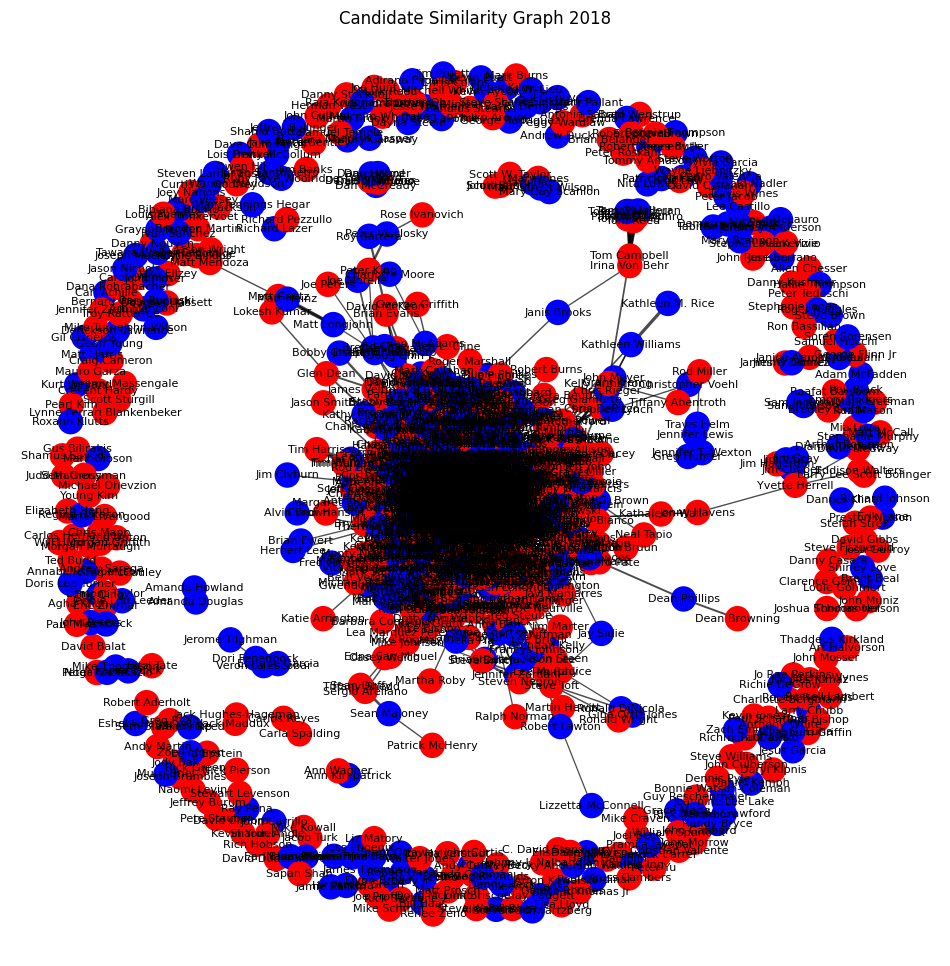

In [22]:
import pandas as pd

# Assuming df1_merged has the relevant columns

df1_merged['combined_issues'] = (
    df1_merged['issue_header'].fillna('') + ' ' +
    df1_merged['issue_text'].fillna('') + ' ' +
    df1_merged['policy_code'].fillna('')
)

candidate_issues = df1_merged.groupby(['candidate_webname', 'year', 'cand_party'])['combined_issues'].apply(lambda texts: ' '.join(texts)).reset_index()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

def build_similarity_graph(df, year, threshold=0.3):
    # Filter candidates from that year
    year_df = df[df['year'] == year].reset_index(drop=True)

    # Vectorize combined issues text
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(year_df['combined_issues'])

    # Compute cosine similarity (square matrix)
    sim_matrix = cosine_similarity(tfidf_matrix)

    # Build graph
    G = nx.Graph()

    # Add nodes: candidate names with year as suffix to avoid ambiguity I reintroduced the ambiguity to simplify the code added next
    nodes = [f"{row['candidate_webname']}" for _, row in year_df.iterrows()]
    G.add_nodes_from(nodes)

    # Adding political party as attribute to each node
    party_dict = year_df.set_index('candidate_webname')['cand_party'].to_dict()
    nx.set_node_attributes(G, party_dict, 'party')

    # Add edges where similarity > threshold (excluding self-loops)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            weight = sim_matrix[i, j]
            if weight > threshold:
                G.add_edge(nodes[i], nodes[j], weight=weight)



    return G

graph_2018 = build_similarity_graph(candidate_issues, 2018)
graph_2020 = build_similarity_graph(candidate_issues, 2020)
graph_2022 = build_similarity_graph(candidate_issues, 2022)

print(f"2018 Graph: {graph_2018.number_of_nodes()} nodes, {graph_2018.number_of_edges()} edges")
print(f"2020 Graph: {graph_2020.number_of_nodes()} nodes, {graph_2020.number_of_edges()} edges")
print(f"2022 Graph: {graph_2022.number_of_nodes()} nodes, {graph_2022.number_of_edges()} edges")

import matplotlib.pyplot as plt

def plot_graph(G, title):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.1)  # Layout adjustment
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    color_map = {'Republican': 'red','Democrat': 'blue'}
    node_colors = [color_map[G.nodes[node]['party']] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_graph(graph_2018, "Candidate Similarity Graph 2018")


In [ ]:
print(f"Density of Graph edges: { nx.density(graph_2018)}")
print(f"Number of components: {nx.number_connected_components(graph_2018)}")

Density of Graph edges: 0.03699573636540961
Number of components: 336


In [ ]:


list(nx.triangles(graph_2018).items())[0:12]



[('A. Donald McEachin', 66),
 ('AJ Kern', 1),
 ('Aaron Godfrey', 0),
 ('Aaron Swisher', 112),
 ('Abby Finkenauer', 123),
 ('Abigail A. Spanberger', 17333),
 ('Adam B. Schiff', 380),
 ('Adam Bell', 31309),
 ('Adam DeMarco', 9436),
 ('Adam Kinzinger', 3849),
 ('Adam McFadden', 0),
 ('Adam Sedlock', 0)]

In [ ]:
# Find the largest connected component
largest_component = max(nx.connected_components(graph_2018), key=len)

# Create a subgraph of the largest connected component
subgraph = graph_2018.subgraph(largest_component)

# Calculate the diameter of the subgraph
diameter = nx.diameter(subgraph)

print(f"Diameter of the largest connected component: {diameter}")

Diameter of the largest connected component: 10


<BarContainer object of 625 artists>

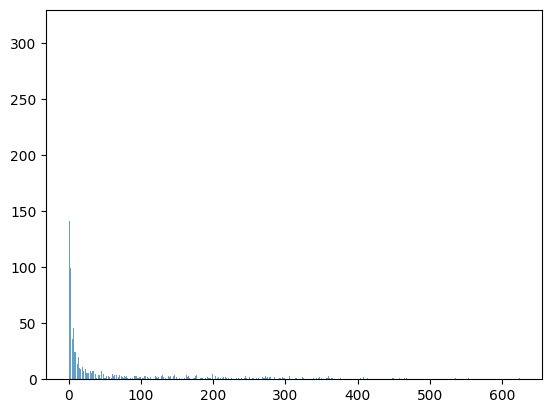

In [ ]:


l = [graph_2018.degree(u) for u in graph_2018.nodes()]

count = [0]*(max(l)+1)
for i in range(max(l)+1):
  count[i] = l.count(i)

plt.bar(range(max(l)+1), count, align='center', alpha=0.7, label='Observed Degree Distribution')

In [ ]:
import numpy as np
xmin = 1
np.ones(len(l))

alpha = 1+(len(l)/sum(np.log((np.array(l)+np.ones(len(l)))/xmin)))
print(alpha)

1.4171383064797125


In [ ]:
#%pip install powerlaw
import powerlaw

fit = powerlaw.Fit(l, discrete=True) # discrete=True for integer degree values
alpha2 = fit.power_law.alpha
xmin = fit.power_law.xmin

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


In [ ]:
  R, p = fit.distribution_compare('power_law', 'lognormal')
  print(f"Power-law vs Lognormal: R={R}, p={p}")

Power-law vs Lognormal: R=-8.147699220904784, p=0.01029478717352481


In [ ]:
alpha2

np.float64(4.41636614002045)

In [ ]:
xmin

np.float64(250.0)

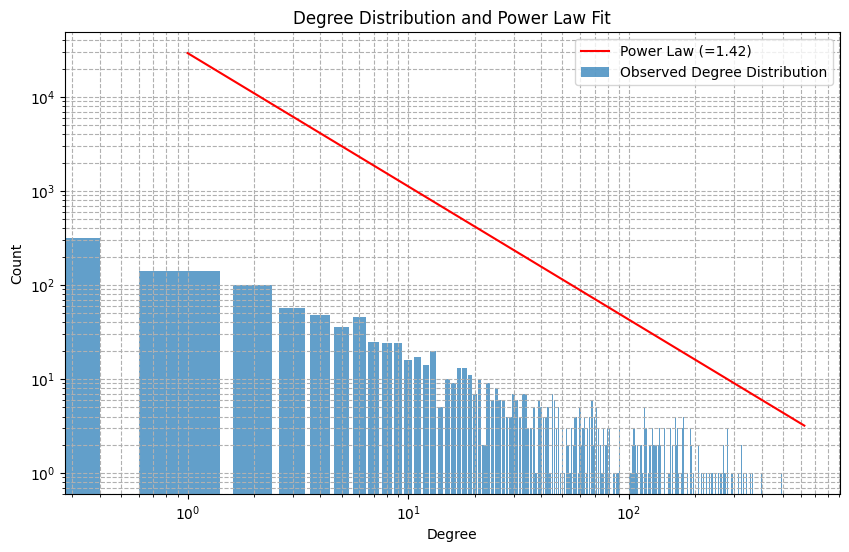

In [ ]:
# Plot the degree distribution as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(max(l)+1), count, align='center', alpha=0.7, label='Observed Degree Distribution')

# Add the powerlaw function to the plot
# Using the estimated alpha from cell zJlv0nOOyKlH
xmin = 1 # Assuming xmin is 1 based on previous cell
alpha = alpha # Using the calculated alpha value
x = np.arange(xmin, max(l) + 1)
# Avoid division by zero for x=0 if xmin is 0
if xmin == 0:
    x = np.arange(1, max(l) + 1)
    powerlaw_y = (x**-alpha) * (len(l) * np.mean(l) / sum(x**-alpha)) # Scale to match sum of degrees
else:
    powerlaw_y = (x**-alpha) * (len(l) * np.mean(l) / sum(x**-alpha)) # Scale to match sum of degrees

# Corrected label string for LaTeX
plt.plot(x, powerlaw_y, 'r-', label=f'Power Law (={alpha:.2f})')

plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution and Power Law Fit')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

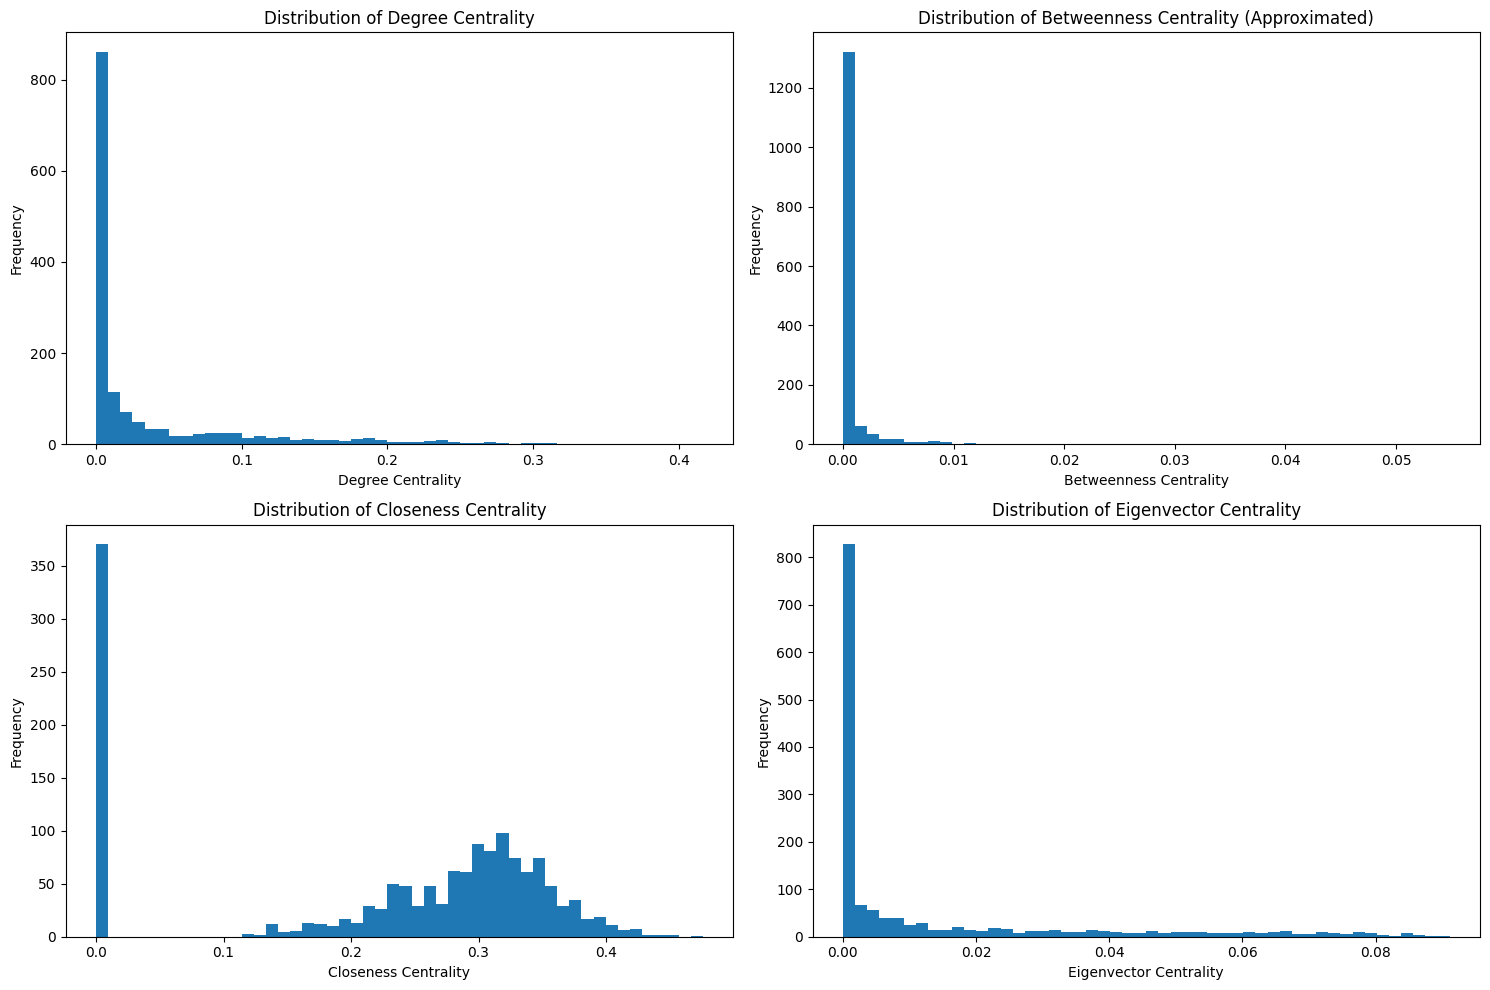

In [ ]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(graph_2018)
betweenness_centrality = nx.betweenness_centrality(graph_2018, k = 100)
closeness_centrality = nx.closeness_centrality(graph_2018)
# Betweenness centrality can be computationally expensive, consider sampling for large graphs
# Using the custom implementation from earlier for consistency, but will use a sample of nodes
# for the full graph or use the NetworkX implementation with k for approximation if needed.
# For now, let's use the built-in with k for approximation on the full graph
# betweenness_centrality = betweenness_centrality(G) # Using custom, but slow for full graph
eigenvector_centrality = nx.eigenvector_centrality(graph_2018, max_iter=1000) # Increased max_iter for convergence

# Create lists of centrality values for plotting
degree_values = list(degree_centrality.values())
betweenness_values = list(betweenness_centrality.values())
closeness_values = list(closeness_centrality.values())
eigenvector_values = list(eigenvector_centrality.values())

# Plot centrality distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(degree_values, bins=50)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')

plt.subplot(2, 2, 2)
plt.hist(betweenness_values, bins=50)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Betweenness Centrality (Approximated)')

plt.subplot(2, 2, 3)
plt.hist(closeness_values, bins=50)
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Centrality')

plt.subplot(2, 2, 4)
plt.hist(eigenvector_values, bins=50)
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvector Centrality')

plt.tight_layout()
plt.show()

Global Clustering Coefficient: 0.5105969977509024


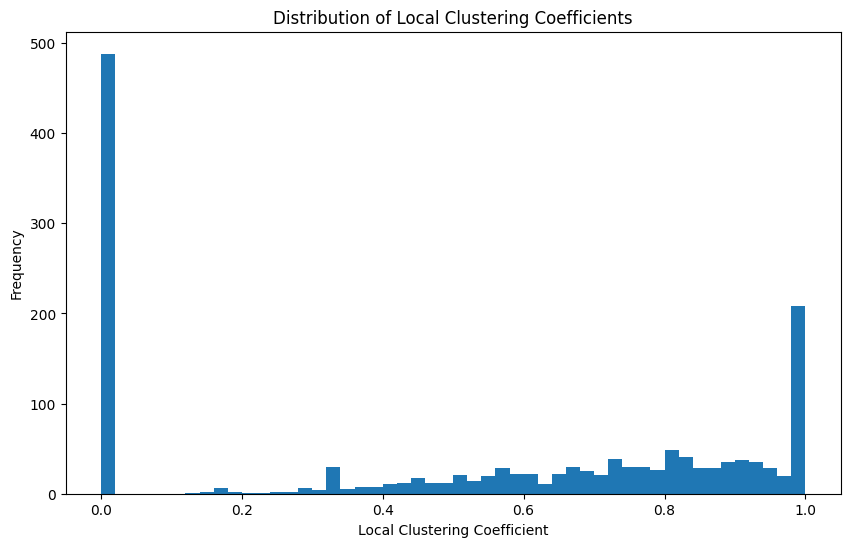

In [ ]:


# Calculate global clustering coefficient
global_clustering = nx.average_clustering(graph_2018)
print(f"Global Clustering Coefficient: {global_clustering}")

# Calculate local clustering coefficients for all nodes
local_clustering = nx.clustering(graph_2018)

# Create a list of local clustering values for plotting
local_clustering_values = list(local_clustering.values())

# Plot the distribution of local clustering coefficients
plt.figure(figsize=(10, 6))
plt.hist(local_clustering_values, bins=50)
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Local Clustering Coefficients')
plt.show()



In [ ]:


nnodes = graph_2018.number_of_nodes()
nedges = graph_2018.number_of_edges()
p = 2*nedges/(nnodes*(nnodes-1))
erg = nx.erdos_renyi_graph(nnodes, p)

bag = nx.barabasi_albert_graph(nnodes, int(nedges/nnodes))

# Generate Configuration Model graph
degree_sequence = [d for n, d in graph_2018.degree()]
cfg = nx.configuration_model(degree_sequence)
# Convert to a simple graph (remove self-loops and parallel edges)
cfg = nx.Graph(cfg)
cfg.remove_edges_from(nx.selfloop_edges(cfg))


# Function to calculate statistics for a graph
def get_graph_stats(graph, name):
    nnodes = graph.number_of_nodes()
    nedges = graph.number_of_edges()
    avg_degree = 2 * nedges / nnodes if nnodes > 0 else 0
    # Get the largest connected component for average path length calculation
    if nx.is_connected(graph):
        avg_path_length = nx.average_shortest_path_length(graph)
    else:
        # Calculate average path length for the largest connected component
        lcc = max(nx.connected_components(graph), key=len)
        subgraph_lcc = graph.subgraph(lcc)
        if subgraph_lcc.number_of_nodes() > 1:
             avg_path_length = nx.average_shortest_path_length(subgraph_lcc)
        else:
            avg_path_length = 0 # Or np.nan, depending on desired representation
    clustering_coefficient = nx.average_clustering(graph)

    return {
        'Graph': name,
        '|V|': nnodes,
        '|E|': nedges,
        'Avg Degree': avg_degree,
        'Avg Path Length (LCC)': avg_path_length,
        'Clustering Coefficient': clustering_coefficient
    }

# Calculate statistics for each graph
stats_G = get_graph_stats(graph_2018, 'Real Graph (G)')
stats_erg = get_graph_stats(erg, 'ER Model')
stats_bag = get_graph_stats(bag, 'BA Model')
stats_cfg = get_graph_stats(cfg, 'Configuration Model')

# Store statistics in a list
all_stats = [stats_G, stats_erg, stats_bag, stats_cfg]

# Create a pandas DataFrame for the comparison table
stats_df = pd.DataFrame(all_stats)

# Display the table
display(stats_df)



,Graph,|V|,|E|,Avg Degree,Avg Path Length (LCC),Clustering Coefficient
0,Real Graph (G),1499,41537,55.419613,2.667512,0.510597
1,ER Model,1499,41337,55.152769,2.089428,0.036923
2,BA Model,1499,39744,53.027352,2.121149,0.089042
3,Configuration Model,1499,32041,42.749833,2.447283,0.256283


In [ ]:
df1_merged.head()

,Unnamed: 0,candidate_webname,state_postal,cd,year,primary_type,dem_prez_vote,cand_party,inc,quality_cand,...,issue_header,issue_text,policy_code,statement_id,housegov_issue,FECCandID,BIOGUIDE_id,housegov_bio,biography_text,combined_issues
0,1,A. Donald McEachin,VA,4,2022,Open Primary,67.2,Democrat,1,2,...,CORONAVIRUS RELIEF,America is facing a grave health emergency wit...,Healthcare,1,0,H6VA04061,NaN,0.0,A community leader with a decades-long commitm...,CORONAVIRUS RELIEF America is facing a grave h...
1,2,A. Donald McEachin,VA,4,2022,Open Primary,67.2,Democrat,1,2,...,REDUCING INEQUITIES IN EDUCATION,Donald understands that good schools prepare c...,Education,2,0,H6VA04061,NaN,0.0,A community leader with a decades-long commitm...,REDUCING INEQUITIES IN EDUCATION Donald unders...
2,3,A. Donald McEachin,VA,4,2022,Open Primary,67.2,Democrat,1,2,...,FIGHTING FOR THE RIGHTS OF ALL VIRGINIANS,"For his entire career, Donald has been fightin...","Civil Rights, Liberties, and Minority Issues",3,0,H6VA04061,NaN,0.0,A community leader with a decades-long commitm...,FIGHTING FOR THE RIGHTS OF ALL VIRGINIANS For ...
3,4,A. Donald McEachin,VA,4,2022,Open Primary,67.2,Democrat,1,2,...,AFFORDABLE HEALTHCARE,Donald believes that affordable healthcare is ...,Healthcare,4,0,H6VA04061,NaN,0.0,A community leader with a decades-long commitm...,AFFORDABLE HEALTHCARE Donald believes that aff...
4,5,A. Donald McEachin,VA,4,2022,Open Primary,67.2,Democrat,1,2,...,PROTECTING OUR ENVIRONMENT,Donald is a stand out leader in the movement t...,Energy and Environment,5,0,H6VA04061,NaN,0.0,A community leader with a decades-long commitm...,PROTECTING OUR ENVIRONMENT Donald is a stand o...


In [ ]:
candidate_party_dict = df1_merged.set_index('candidate_webname')['cand_party'].to_dict()

nx.set_node_attributes(graph_2018,candidate_party_dict, 'candidate_party')

In [ ]:
graph_2018.nodes['A. Donald McEachin']

{'candidate_party': 'Democrat'}

In [ ]:
nx.get_node_attributes(graph_2018, 'candidate_party')

{}

In [ ]:
candidate_party_dict = df1_merged.set_index('candidate_webname')['cand_party'].to_dict()

# Display the first few items of the dictionary
list(candidate_party_dict.items())[:10]

[('A. Donald McEachin', 'Democrat'),
 ('A.J. Louderback', 'Republican'),
 ('Aarika Samone Rhodes', 'Democrat'),
 ('Aaron Bashir', 'Republican'),
 ('Aaron Storer', 'Republican'),
 ('Jamal Abdulahi', 'Democrat'),
 ('Abel Mulugheta', 'Democrat'),
 ('Kevin Abel', 'Democrat'),
 ('Tiffany Abentroth', 'Republican'),
 ('Kent Abernathy', 'Republican')]